# Laden der Daten und Inspizieren der Daten (kopiert)

In [1]:
notebook_title = "unet_data_augmented_tuner"

In [2]:
%run ./utils/load_data.ipynb

/home/aie3/albert/flood-area-segmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No of images:  290
No of masks:  290
(290, 224, 224, 3)
Loaded 290 images and masks.


# Data augmentation


In [3]:
# import import_ipynb
# from utils.data_augmentation import augment

# augmented_images, augmented_masks = augment(images, masks)

%run ./utils/data_augmentation.ipynb

print("Dataset size before augmentation: ", images.shape[0])
print("Dataset size after augmentation:", augmented_images.shape[0])

Dataset size before augmentation:  290
Dataset size after augmentation: 2610


### Auteilung in Train und Validation Daten
- 70% Training
- 15% Validierung
- 15% Test

In [4]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (1827, 224, 224, 3)
Val:   (391, 224, 224, 3)
Test:  (392, 224, 224, 3)


#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

In [5]:
# limit the usage of GPU memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-06-18 01:46:24.321761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750211184.341032 3865228 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750211184.347026 3865228 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750211184.362324 3865228 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750211184.362344 3865228 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750211184.362346 3865228 computation_placer.cc:177] computation placer alr

# Model

Tune hyperparameters

In [30]:
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

%run ./utils/u_net_v4_tuner.ipynb

# final_model, best_hps = run_hyperparameter_search(build_unet_model, X_train, y_train, X_val, y_val)

Best val_iou_metric So Far: 0.8095970153808594

Total elapsed time: 00h 31m 48s

## Found best hyperparameters

Best dropout rate: 0.05

Best learning rate: 0.00017976711346215894

Best base filters: 32

Use batch norm: True

In [41]:
model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3), 0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00017976711346215894), loss='binary_crossentropy', metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 112, 112,  │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 112, 112,  │     18,496 │ dropout_35[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 56, 56,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 56, 56,    │     73,856 │ dropout_36[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_80[0][0] 

 Total params: 1,952,513 (7.45 MB)

 Trainable params: 1,949,697 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [42]:
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 335ms/step - accuracy: 0.7324 - f1_metric: 0.7110 - iou_metric: 0.5622 - loss: 0.5122 - precision_metric: 0.7045 - recall_metric: 0.7213 - val_accuracy: 0.3765 - val_f1_metric: 0.5685 - val_iou_metric: 0.3976 - val_loss: 0.7968 - val_precision_metric: 0.3983 - val_recall_metric: 0.9959
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8244 - f1_metric: 0.8151 - iou_metric: 0.6887 - loss: 0.3559 - precision_metric: 0.8313 - recall_metric: 0.8025 - val_accuracy: 0.3754 - val_f1_metric: 0.5691 - val_iou_metric: 0.3982 - val_loss: 1.4414 - val_precision_metric: 0.3982 - val_recall_metric: 1.0000
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8426 - f1_metric: 0.8388 - iou_metric: 0.7227 - loss: 0.3125 - precision_metric: 0.8535 - recall_metric: 0.8268 - val_accuracy: 0.3754 - val_f1_metric: 0.5691 - val_iou_metric: 0.3982 - val_loss: 3.2931 - val_precision_metric: 0.3982 - val_recall_metric: 1.0000
Epoch 4/50
58/58 

Die Werte der Metrik "Intersection over Union (IoU)" hat sich eigentlich nicht verbessert auf dem Validation Set. Es war schon besser ohne Dropout.

# Nach 50 Epochen

## 2025-06-17
accuracy: 0.9168 - f1_metric: 0.9343 - iou_metric: 0.8769 - loss: 0.1303 - precision_metric: 0.9393 - recall_metric: 0.9299 - val_accuracy: 0.9016 - val_f1_metric: 0.9128 - val_iou_metric: 0.8397 - val_loss: 0.1857 - val_precision_metric: 0.9065 - val_recall_metric: 0.9193

## 2025-06-17
accuracy: 0.9170 - f1_metric: 0.9335 - iou_metric: 0.8753 - loss: 0.1317 - precision_metric: 0.9379 - recall_metric: 0.9296 - val_accuracy: 0.8983 - val_f1_metric: 0.9106 - val_iou_metric: 0.8360 - val_loss: 0.1932 - val_precision_metric: 0.8839 - val_recall_metric: 0.9391

## 2025-06-17
accuracy: 0.9088 - f1_metric: 0.9226 - iou_metric: 0.8566 - loss: 0.1515 - precision_metric: 0.9240 - recall_metric: 0.9218 - val_accuracy: 0.9002 - val_f1_metric: 0.9107 - val_iou_metric: 0.8361 - val_loss: 0.1901 - val_precision_metric: 0.9149 - val_recall_metric: 0.9067

## Model speichern

In [43]:
model.save(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

# Diagramme

In [44]:
print(history.history.keys())

dict_keys(['accuracy', 'f1_metric', 'iou_metric', 'loss', 'precision_metric', 'recall_metric', 'val_accuracy', 'val_f1_metric', 'val_iou_metric', 'val_loss', 'val_precision_metric', 'val_recall_metric'])


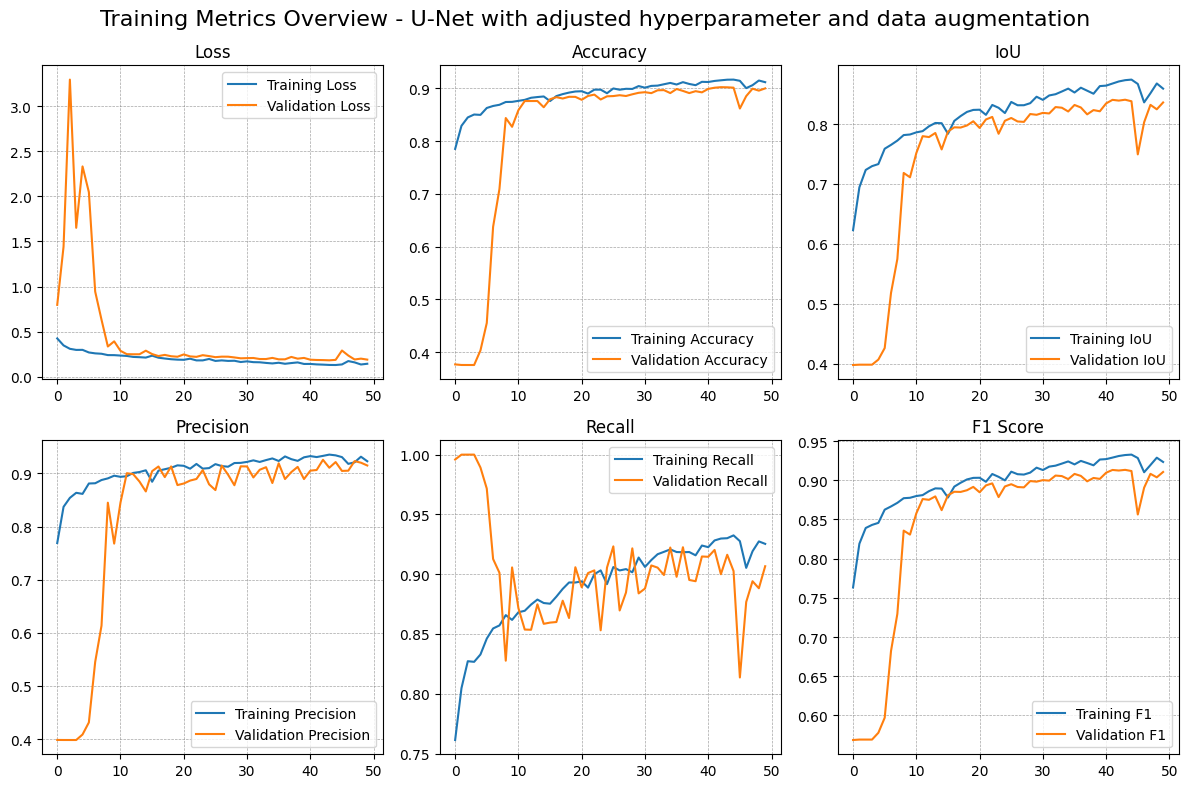

In [45]:
# Plot training history
from datetime import datetime
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color


plt.suptitle('Training Metrics Overview - U-Net with adjusted hyperparameter and data augmentation', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was die Diagramme zeigen:

Das getunte Netz ist bessert als das U-Net v3 Netz.

### Modell evaluieren mit Testdaten

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step

===== Final Test Evaluation =====
Precision: 0.9130
Recall:    0.9101
F1 Score:  0.9116
IoU:       0.8375



## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9052
Recall:    0.9193
F1 Score:  0.9122
IoU:       0.8386

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.8823
Recall:    0.9412
F1 Score:  0.9108
IoU:       0.8362

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9130
Recall:    0.9101
F1 Score:  0.9116
IoU:       0.8375

#### Vergleich der Metriken für Train, Validation und Test

In [47]:
import import_ipynb
from utils.metrics_barplot import metrics_summary

metrics_summary_results = metrics_summary(history, y_true_flat, y_pred_flat, precision, recall, f1, iou)

print("\n===== Training, Validation und Test Metriken =====")
print(metrics_summary_results.to_string(index=False, float_format="%.4f"))


===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.9119     0.9229  0.9254    0.9234 0.8592
  Val    0.9002     0.9149  0.9067    0.9107 0.8361
 Test    0.9300     0.9130  0.9101    0.9116 0.8375


Es sieht nicht so aus, als es sich etwas verbessert hat im Vergleich zu U_net mit dropout


## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.9192     0.9388  0.9341    0.9362 0.8802
  Val    0.9016     0.9065  0.9193    0.9128 0.8397
 Test    0.9298     0.9052  0.9193    0.9122 0.8386

## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.9180     0.9399  0.9312    0.9352 0.8785
  Val    0.8983     0.8839  0.9391    0.9106 0.8360
 Test    0.9269     0.8823  0.9412    0.9108 0.8362

## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.9119     0.9229  0.9254    0.9234 0.8592
  Val    0.9002     0.9149  0.9067    0.9107 0.8361
 Test    0.9300     0.9130  0.9101    0.9116 0.8375

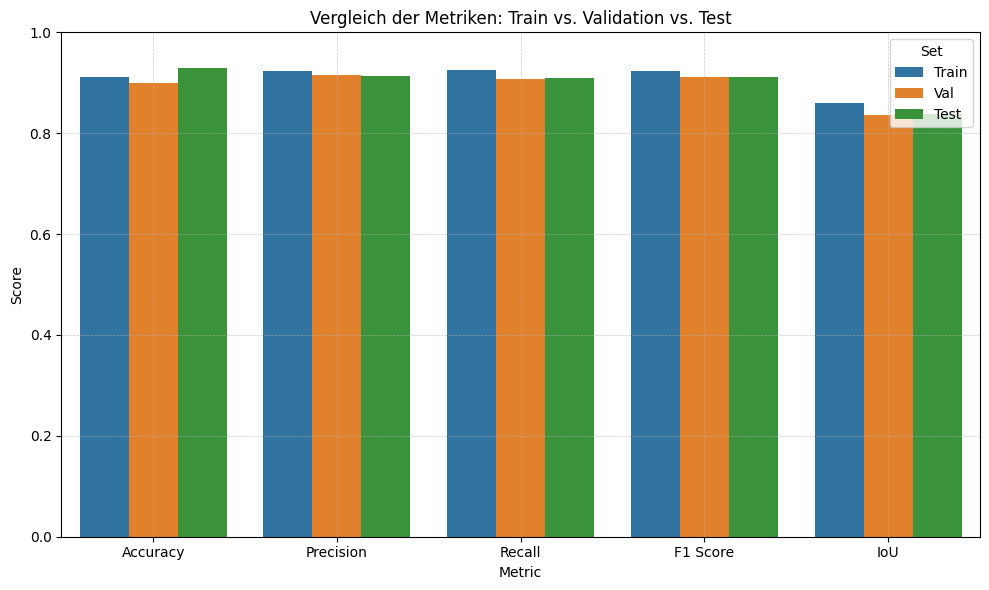

In [48]:
import import_ipynb
from utils.metrics_barplot import draw_metrics_barplot

draw_metrics_barplot(metrics_summary_results, save_title=f"{notebook_title}_batch_size_{BATCH_SIZE}")

# Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


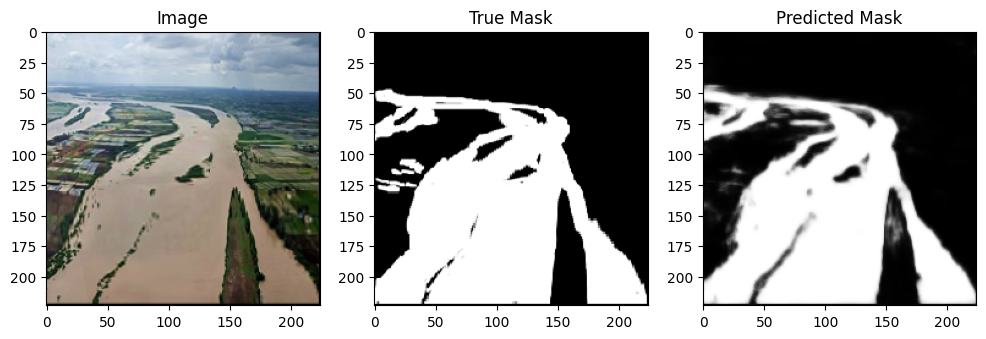

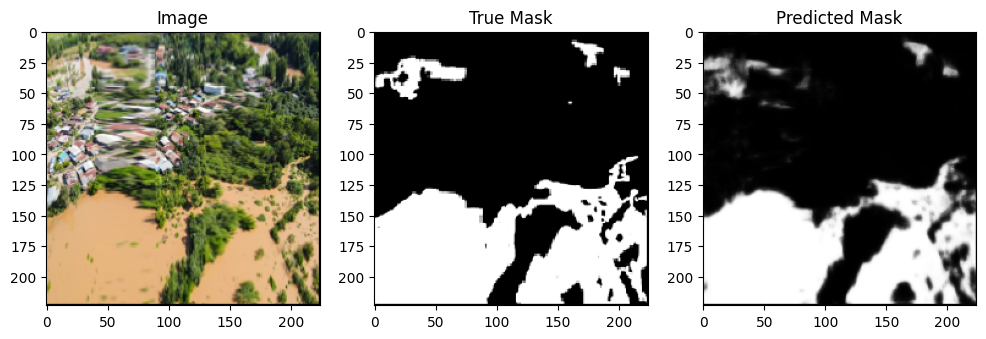

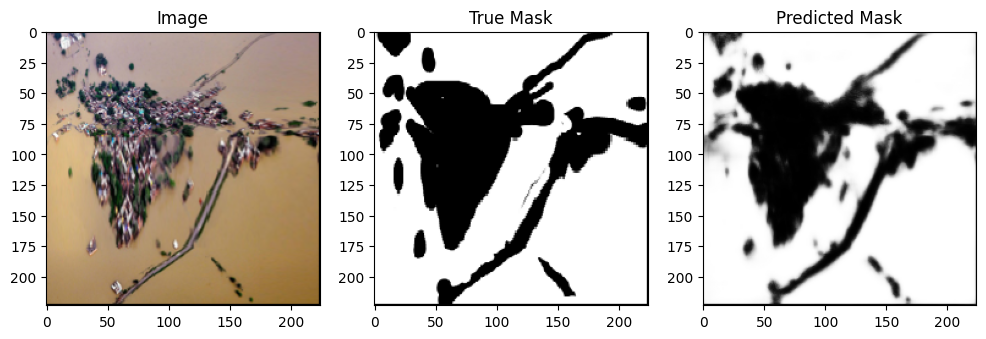

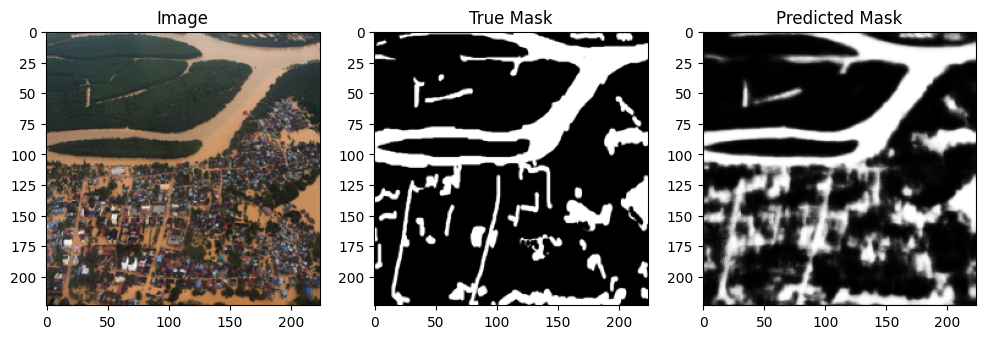

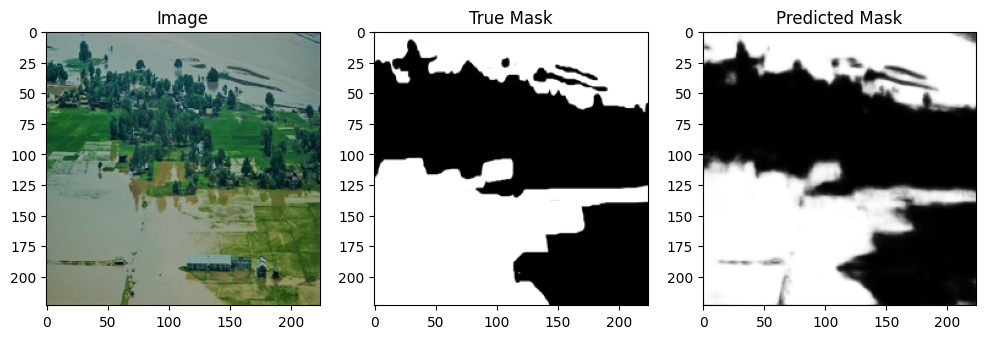

In [49]:
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import load_model

# Imports relevant for loading the model
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

def visualize_predictions(num_images=5):
    preds = model.predict(X_test[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_test[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')


        plt.savefig(f'./img/visualized_predictions/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
        plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


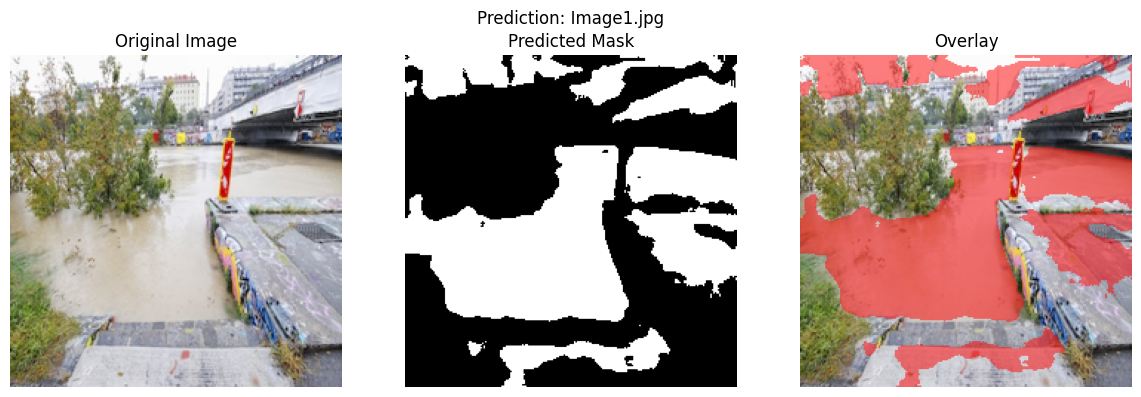

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


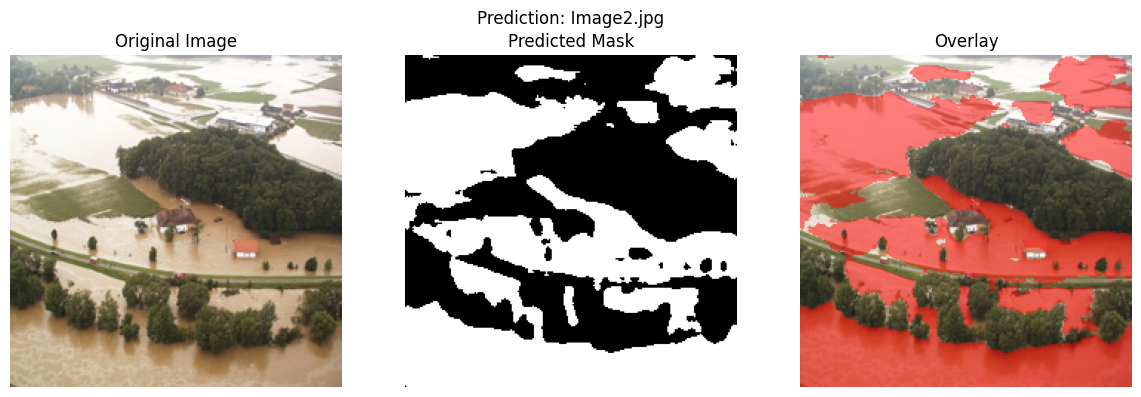

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


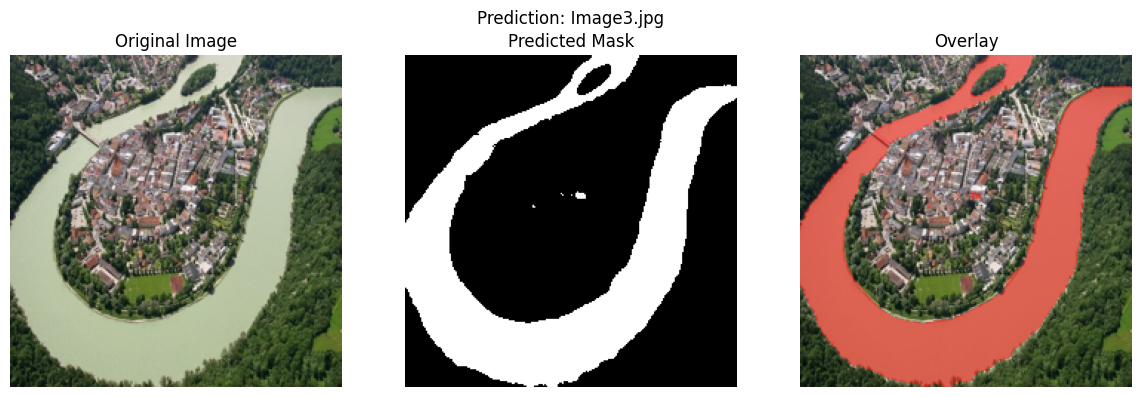

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


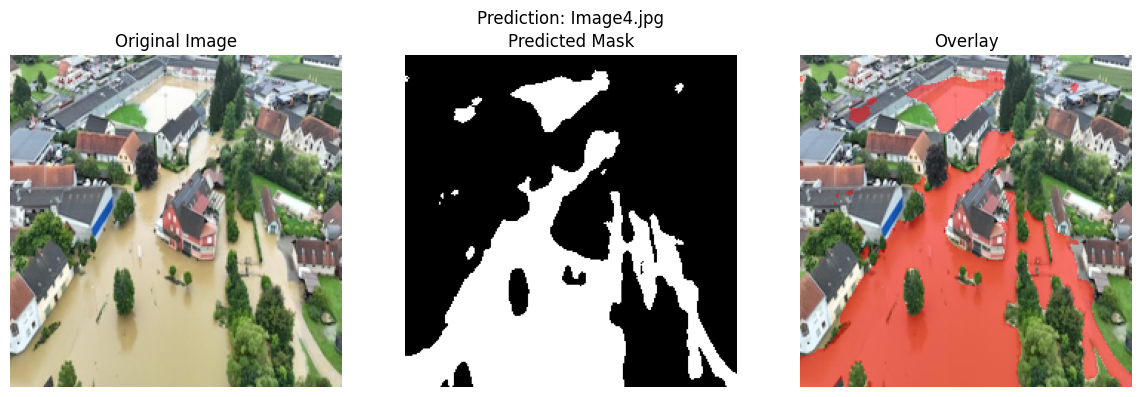

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


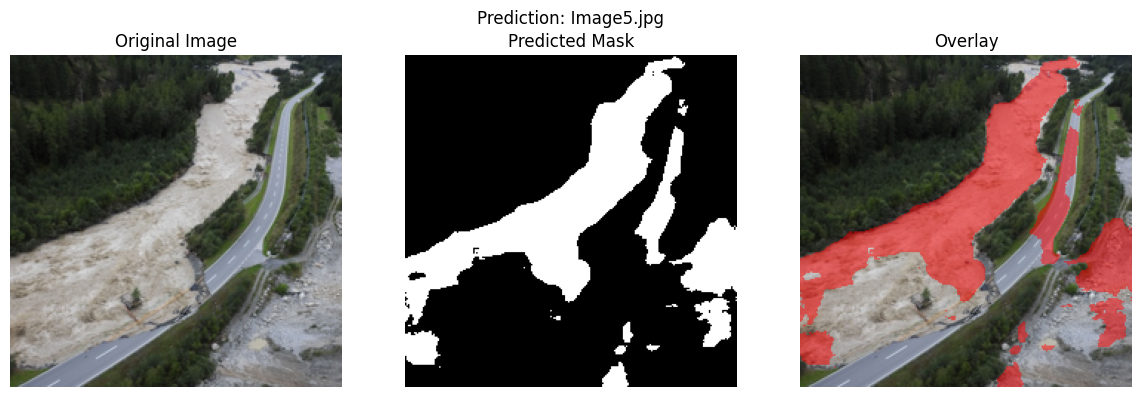

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


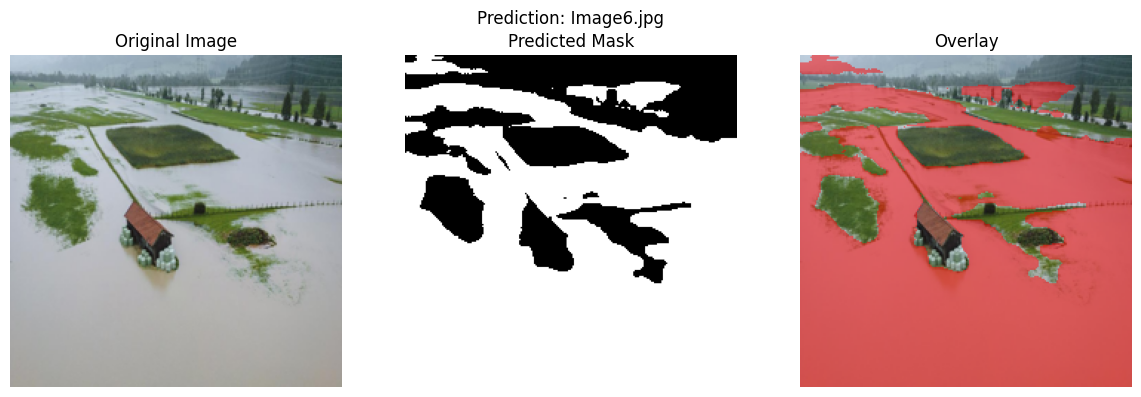

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


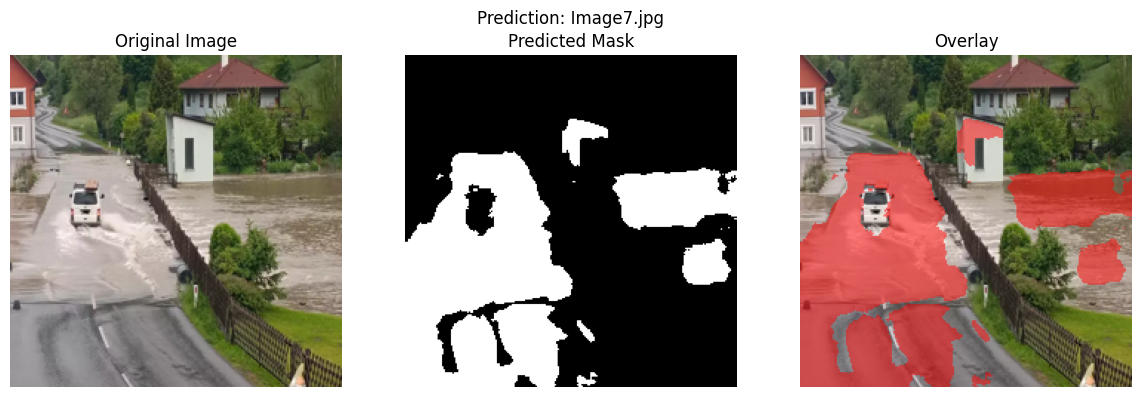

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [50]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
        image_resized=np.array(image_resized), 
        pred_binary=pred_binary, 
        img_file=img_file,
        alpha=ALPHA,
        is_saved=True,
        save_title=f"adjusted_hyperparameter_batch_size_64"
    )